In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import os


In [ ]:
# Set workspace
workspace_path = r"C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master"
os.chdir(workspace_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master


In [ ]:
#Load Time Series Dataset from CSV
path = "data//artificialNoAnomaly//art_daily_small_noise.csv"
df = pd.read_csv(path)
time = df['timestamp']
demand = df['value'].values
df


,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120
...,...,...
4027,2014-04-14 23:35:00,20.211195
4028,2014-04-14 23:40:00,20.531041
4029,2014-04-14 23:45:00,19.032127
4030,2014-04-14 23:50:00,21.798801


In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)


In [ ]:
#Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Forecast Future Values
predictions = model.predict(X)
df["forecast"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [77]:
# Step 6: Detect Anomalies (Based on Forecast Error)
df["error"] = abs(df["value"] - df["forecast"])
threshold = df["error"].mean() + 1 * df["error"].std()  # Define anomaly threshold
df["anomaly"] = df["error"] > threshold


In [ ]:
# Mitigate Anomalies Using Moving Average Smoothing
window_size = 9
df["smoothed_value"] = df["value"].rolling(window=window_size, center=True).mean()

#df["smoothed_value"] = df["forecast"].ewm(span=10, adjust=False).mean() #EVA

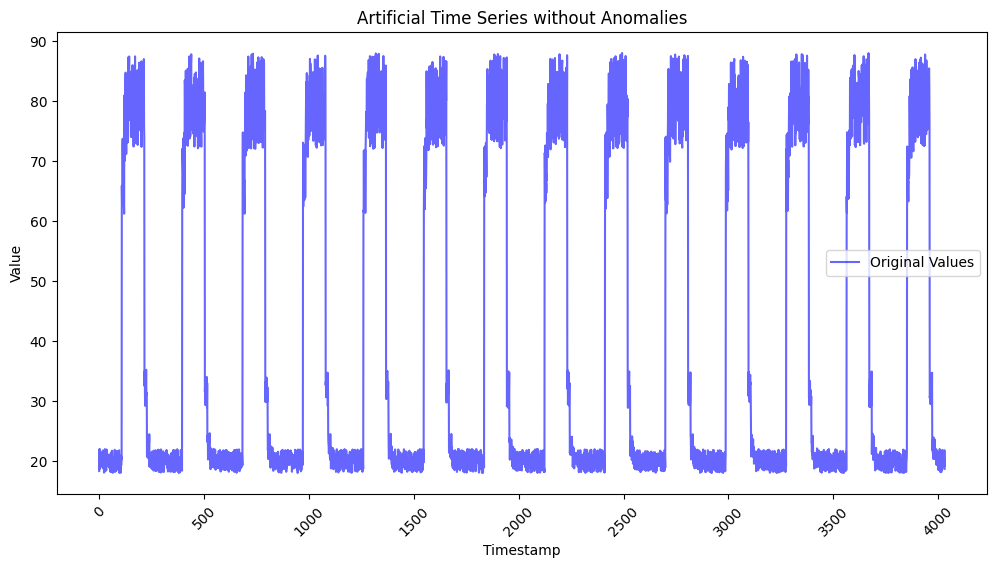

In [ ]:
#  Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["value"], label="Original Values", color="blue", alpha=0.6)
#plt.plot(df.index, df["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", zorder =3, linewidth=0.7)
#plt.scatter(df.index[df["anomaly"]], df["value"][df["anomaly"]], color="red", label="Anomalies", marker="x")
#plt.plot(df.index, df["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Artificial Time Series without Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()


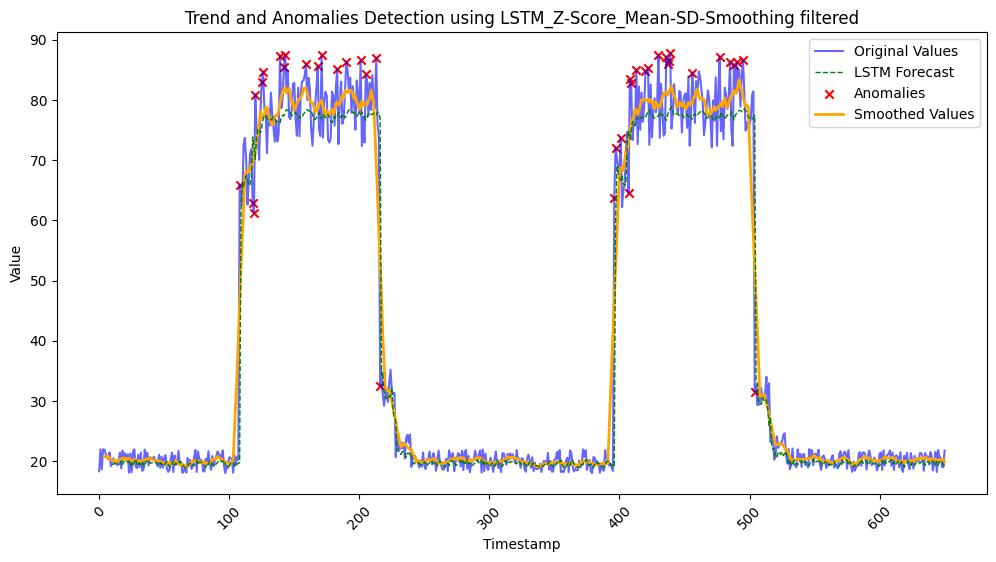

In [80]:
# Filter the dataset for the specific date range
df_filtered = df.iloc[0:651]

# Plot only the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df_filtered.index, df_filtered["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", zorder=3, linewidth=1)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Trend and Anomalies Detection using LSTM_Z-Score_Mean-SD-Smoothing filtered")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

In [81]:
print(df[df["anomaly"] == True])
print(len(df[df["anomaly"] == True]))

                timestamp      value  scaled_value   forecast      error  \
108   2014-04-01 09:00:00  65.861141      0.683959  19.733294  46.127847   
118   2014-04-01 09:50:00  62.807773      0.640324  73.846100  11.038327   
119   2014-04-01 09:55:00  61.200418      0.617354  72.032211  10.831794   
120   2014-04-01 10:00:00  80.892367      0.898767  70.146194  10.746172   
125   2014-04-01 10:25:00  83.049859      0.929600  75.592667   7.457193   
...                   ...        ...           ...        ...        ...   
3944  2014-04-14 16:40:00  86.747460      0.982441  77.281677   9.465783   
3953  2014-04-14 17:25:00  84.511997      0.950495  77.127823   7.384174   
3957  2014-04-14 17:45:00  85.417916      0.963441  78.047211   7.370705   
3960  2014-04-14 18:00:00  30.553670      0.179388  77.734718  47.181049   
3971  2014-04-14 18:55:00  34.704457      0.238706  26.067802   8.636654   

      anomaly  smoothed_value  
108      True       46.518900  
118      True       69.

In [82]:
#Complet neue Forecast mit neuen gesmoothten values

In [ ]:
# Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value_smoothed"] = scaler.fit_transform(df[["smoothed_value"]])

In [ ]:
# Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value_smoothed"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value_smoothed"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)


In [ ]:
#  Forecast Future Values
predictions = model.predict(X)
df["forecast_smoothed"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast_smoothed")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


In [ ]:
# Define and Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#  Detect Anomalies (Based on Forecast Error)
df["error_smooth"] = abs(df["smoothed_value"] - df["forecast_smoothed"])
threshold = df["error"].mean() + 1 * df["error"].std()  # Keep same anomaly threshold
df["smoothed_anomaly"] = df["error_smooth"] > threshold

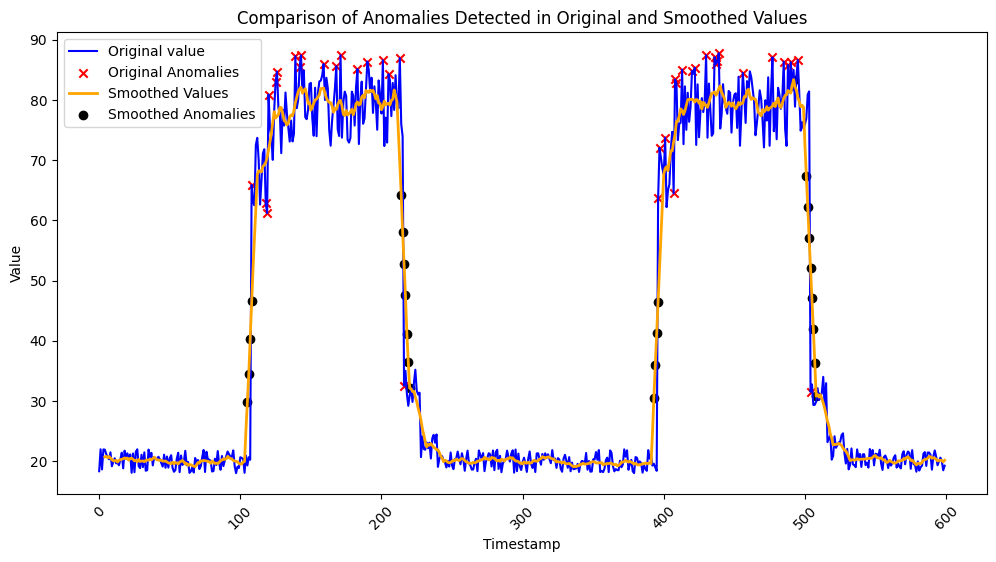

Original Anomalies Detected: 326
Smoothed Anomalies Detected: 189
Anomalies Reduced: 137


In [ ]:
df_filtered = df.iloc[0:600]

plt.figure(figsize=(12, 6))

plt.plot(df_filtered.index, df_filtered["value"], label="Original value", color="blue", alpha=1)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Original Anomalies", marker="x")

plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2, zorder=3)
plt.scatter(df_filtered.index[df_filtered["smoothed_anomaly"]], df_filtered["smoothed_value"][df_filtered["smoothed_anomaly"]], color="black", label="Smoothed Anomalies", marker="o")

plt.title("Comparison of Anomalies Detected in Original and Smoothed Values")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

original_anomalies_count = df["anomaly"].sum()
smoothed_anomalies_count = df["smoothed_anomaly"].sum()

print(f"Original Anomalies Detected: {original_anomalies_count}")
print(f"Smoothed Anomalies Detected: {smoothed_anomalies_count}")
print(f"Anomalies Reduced: {original_anomalies_count - smoothed_anomalies_count}")

In [89]:
df

,timestamp,value,scaled_value,forecast,error,anomaly,smoothed_value,scaled_value_smoothed,forecast_smoothed,error_smooth,smoothed_anomaly
0,2014-04-01 00:00:00,18.324919,0.004630,NaN,NaN,False,NaN,NaN,NaN,NaN,False
1,2014-04-01 00:05:00,21.970327,0.056725,NaN,NaN,False,NaN,NaN,NaN,NaN,False
2,2014-04-01 00:10:00,18.624806,0.008915,NaN,NaN,False,NaN,NaN,NaN,NaN,False
3,2014-04-01 00:15:00,21.953684,0.056487,NaN,NaN,False,NaN,NaN,NaN,NaN,False
4,2014-04-01 00:20:00,21.909120,0.055851,NaN,NaN,False,20.707939,0.027389,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
4027,2014-04-14 23:35:00,20.211195,0.031586,19.393475,0.817720,False,19.785227,0.013177,20.137472,0.352245,False
4028,2014-04-14 23:40:00,20.531041,0.036157,19.623087,0.907954,False,NaN,NaN,20.072544,NaN,False
4029,2014-04-14 23:45:00,19.032127,0.014736,19.799400,0.767273,False,NaN,NaN,NaN,NaN,False
4030,2014-04-14 23:50:00,21.798801,0.054274,19.458408,2.340393,False,NaN,NaN,NaN,NaN,False


In [90]:
original_variance = np.var(df["value"])
smoothed_variance = np.var(df["smoothed_value"])

print(f"Original Variance: {original_variance:.4f}")
print(f"Smoothed Variance: {smoothed_variance:.4f}")
print(f"Variance Reduction: {original_variance - smoothed_variance:.4f}")

Original Variance: 788.1293
Smoothed Variance: 755.7372
Variance Reduction: 32.3920
